In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("compas-scores-two-years-violent.csv", index_col=0)

In [7]:
y = y = df['two_year_recid']
keep_cols = [
    'age',             # defendant age
    'sex',             # male/female
    'race',            # categorical
    'priors_count',    # number of prior offenses
    'c_charge_degree'  # felony vs misdemeanor
]

X_safe = df[keep_cols].copy()

# Convert categorical variables to dummy/indicator variables
X= pd.get_dummies(X_safe, drop_first=True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)


In [16]:
# Model Accuracy
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.83
Precision: 0.64
Recall: 0.08


In [10]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[972,   9],
       [189,  16]])

Text(0.5, 427.9555555555555, 'Predicted label')

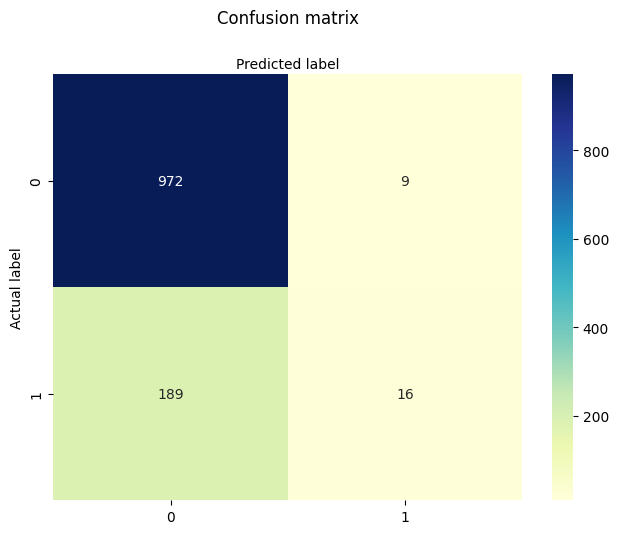

In [15]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Biasness in Logistic Regression Classifier on COMPASS :

False‐positive rate (FPR)
Among those who did not actually recidivate, 1.54% of Black defendants are incorrectly flagged, versus 0.56% of White defendants. So innocent Black defendants are nearly 3× more likely to get a false “High” label. The FPR gap (1.54% vs 0.56%) is evidence of disparate false alarms against Black defendants—a classic sign of bias against that group.

False‐negative rate (FNR)
Among those who did recidivate, the model misses 89.4% of Black recidivists but misses an even higher 98.3% of White recidivists. The classifier is comparatively better at catching Black recidivists than White ones.

In [17]:
def group_stats(g):
    tn, fp, fn, tp = confusion_matrix(
        g['true'], 
        g['pred'],
        labels=[0,1]
    ).ravel()
    return {
        'P(recid_pred=1)': (tp+fp)/len(g),
        'FPR':  fp / (fp + tn) if (fp+tn)>0 else 0,
        'FNR':  fn / (fn + tp) if (fn+tp)>0 else 0,
        'Accuracy': (tp + tn) / len(g)
    }

results = X_test.copy()
results['true'] = y_test
results['pred'] = y_pred

# re-add race and sex from the original df
results['race'] = df.loc[X_test.index, 'race']
results['sex']  = df.loc[X_test.index, 'sex']
# by race
by_race   = results.groupby('race').apply(lambda g: pd.Series(group_stats(g)))
# by gender
by_gender = results.groupby('sex').apply(lambda g: pd.Series(group_stats(g)))

print("Metrics by Race:\n", by_race)
print("\nMetrics by Gender:\n", by_gender)

Metrics by Race:
                   P(recid_pred=1)       FPR       FNR  Accuracy
race                                                           
African-American         0.034542  0.015351  0.894309  0.797927
Asian                    0.000000  0.000000  0.000000  1.000000
Caucasian                0.007299  0.005666  0.982759  0.856448
Hispanic                 0.008696  0.000000  0.923077  0.895652
Native American          0.000000  0.000000  0.000000  1.000000
Other                    0.014286  0.000000  0.909091  0.857143

Metrics by Gender:
         P(recid_pred=1)       FPR       FNR  Accuracy
sex                                                  
Female         0.000000  0.000000  1.000000  0.890351
Male           0.026096  0.011568  0.911111  0.819415


/var/folders/6c/pmclr21d7qxghrnljkq0f9pc0000gn/T/ipykernel_22650/2085525822.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_race   = results.groupby('race').apply(lambda g: pd.Series(group_stats(g)))
/var/folders/6c/pmclr21d7qxghrnljkq0f9pc0000gn/T/ipykernel_22650/2085525822.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_gender = results.groupby('sex').apply(lambda g: pd.Series(group_stats(